# 1. Understanding the data

<span style="font-size:14px;font-family: Arial;line-height:1.5">
As always, the first step in any data analysis pipeline is to understand what you're looking at. The strategy one uses to look at the data can depend on where you're coming from. If you're a domain expert, you may already have some intutitions about what to expect; even the average person will have some expectations about the behavior of different measurements. We should be aware that these expectations will shape how we interpret any data we receive, but also remember that such expectations are built on years of experience that can help us understand what we're looking at in more detail.
</p><p>
Often through investigation, the stories of the data become clearer. This may be important when designing models, understanding model outputs and communicating with others.

</p></span>

## 1.1. General Background

<span style="font-size:14px;font-family: Arial;line-height:1.5">
It is important to appreciate that this data was obviously not collected in a well-controlled experiment. From a scientific perspective, this is important in shaping how we think about features and interpret missing data (chapter 2).

Let's start by loading the data and seeing what we've got. We know that each row in the table represents one passenger, but how many passengers are in test and train datasets?
</span>

In [1]:
from pathlib import Path
import pandas as pd

data_dir = Path.cwd().parent.parent / 'data/titanic'

train = pd.read_csv(data_dir / 'train.csv')
print(f"Training data: {train.shape[0]} passengers")       

test = pd.read_csv(data_dir / 'test.csv')
print(f"Testing data: {test.shape[0]} passengers")       

Training data: 891 passengers
Testing data: 418 passengers


<span style="font-size:14px;line-height:1.5">
Let's also see what features are available in the data (this can also be found on the Kaggle Website). If we were looking at an undocumented dataset, this step would be important also in confirming if there were features in the training dataset that were not available in the test set. Here, the only difference is the 'Survived' column that contains the target labels for prediction; however in more challenging datasets, we may find features that are absent from the test set. 
</span>

In [2]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
print(f"Columns in both test and train data: {[x for x in train.columns if x in test.columns]}")
print(f"Columns in only training data: {[x for x in train.columns if x not in test.columns]}")

Columns in both test and train data: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Columns in only training data: ['Survived']


<span style="font-size:14px;line-height:1.5">
We could use methods such as <b>describe()</b> or the pandas profiling library to generate reports on the statistics of different columns. These are useful tools that we'll take 
advantage of in later chapters; however we already know that we're going to look through the data in detail (this isn't a 30 minute coding challenge, or 12 minute YouTube video), so we can skip these intermediate steps and get straight into visualizing the data.
</span><br></br>


## 1.2. Main Effects: Thinking about individual features

### 1.2.1. Age


<span style="font-size:14px;line-height:1.5">
What background information do we have? We know that ages can't be negative and should probably be in the range of 0 to 150, if recorded in years. From Kaggle, we also have a note that:</span>
<br></br>
<span style="font-size:14px;font-weight:200;line-height:1.5;margin-left:10px">"Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5"</span>
<br></br>
<span style="font-size:14px;line-height:1.5">
Let's start by using the <b>describe</b> function to get the basic details about Age:
</span>

In [4]:
train['Age'].describe(percentiles=[0.5])

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
50%       28.000000
max       80.000000
Name: Age, dtype: float64

<span style="font-size:14px;line-height:1.5">
<p>
We can see the min (0.42) and max values (80.0) are sensible, but the count (714/891) shows that there are many passengers for which age data is missing. Missing data is important, and Chapter 2 goes into more detail on how we might manage such situations. 
</p><p>
In the case of Age, we can contrast missing data with ages that are observed or estimated (see the note from Kaggle above). The fact that some ages have to be estimated may be important - for example, if the passenger didn't survive and thus couldn't provide the information. The same may be true for missing data and such clues are present throughout the titanic dataset to help us build a more complete picture of the ship and data collection process. 
</p><p>
Let's therefore create a column that indicates whether Age data is 'observed', 'estimated' or 'missing' by using <b>apply()</b> to implement a custom function. We can use the <b>value_counts()</b> method to double check that the results look sensible.</p></span>

In [5]:
import numpy as np

def get_age_measurement_type(x):            # there may be nicer ways of writing this function but it does the job
    if np.isnan(x):
        return 'missing'
    else:
        if (x - np.floor(x)) == 0.5:
            return 'estimated'        
    return 'observed'

train['age_measure'] = train['Age'].apply(get_age_measurement_type)
test['age_measure'] = test['Age'].apply(get_age_measurement_type)

train['age_measure'].value_counts()

observed     696
missing      177
estimated     18
Name: age_measure, dtype: int64

<span style="font-size:14px;font-family: Arial;line-height:1.5">
We can then use the groupby function to ask if survival rates differed for each measurement type:
</span>

In [6]:
train.groupby('age_measure')['Survived'].mean()     # returns proportion survived (0=none, 1=all)

age_measure
estimated    0.055556
missing      0.293785
observed     0.415230
Name: Survived, dtype: float64

<span style="font-size:14px;line-height:1.5">
<p>The intuitions we had about estimates being made when passengers perished seems to be accurate, and a similar, although weaker pattern is true for missing data. We might also have expectations about survival depending on age, and particularly that children should have been prioritised in the evacuation of the ship. Is this true?
</p><p>
To answer this, we're going to collect data into age groups, which are commonly used for such data. This collection, or binning of data isn't always a good idea, because it's removing ifnormation. We use it here to show the trends in the data for us to see as humans, while averaging out some of the noise in age measurements. In later chapters, we will build models using the original input data as ML solutions don't need as much help as we do...
</p><span>

In [7]:
def round_to_agegroup(x, interval=5):
    return (np.floor(x / interval) * interval) + (interval/2)

train['age_group'] = train['Age'].apply(round_to_agegroup)
test['age_group'] = test['Age'].apply(round_to_agegroup)

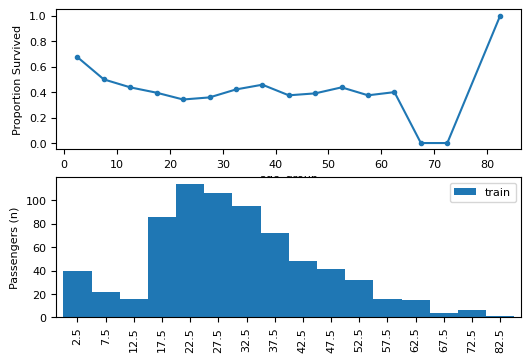

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})

# Plot survival rate and number of passengers for each age group
fig, axs = plt.subplots(2,1, **{'figsize':(6,4)})

train.groupby('age_group')['Survived'].mean().plot(ax=axs[0], **{'marker':'.'})

train['age_group'].value_counts().sort_index().plot.bar(
    ax=axs[1], **{'width':1,'label':'train','lw':0})

axs[0].set_ylabel('Proportion Survived')
axs[1].set_ylabel('Passengers (n)')

plt.legend()
plt.show()

<span style="font-size:14px;line-height:1.5">
The top plot above confirms our theory that children younger then 5 tended to be more likely to survive. In the bottom plot, we drew the number of passengers in each group; this indicates that passenger age may not be normally distributed, with a pronounced absence of children between 5 and 15 years old on the ship.
<p></p>
The probability distribution of a feature is very important as it determines how we model that feature and any tranformations we might use before model fitting. 

One way to advance our knowledge is to use a statistical measure that asks whether Age data follows a normal distribution. Below we'll use the <b>Kolmogorov-Smirnov test</b> to compare the empirical distribution function of the test data with the cumulative distribution function of a reference distribution - in this case, a normal distribution. The test returns a statistic that tends to zero when the observed distribution matches the reference, or increases towards 1 (not sure if this is the upper bound though) as the distributions differ. One can also use a p-value to decided how likely the two distributions are to match.
</span>

In [9]:
from scipy.stats import kstest
kstest(train['Age'].dropna().to_numpy(), 'norm')

KstestResult(statistic=0.9650366565902186, pvalue=0.0)

<span style="font-size:14px;line-height:1.5">We see that the KS statistic is close to one, and the p-value is close to zero, indicating that Age data is very unlikely to follow a normal (Gaussian) distribution. This shouldn't be surprising as we know that ages below zero are impossible; more generally, we might ask why age should follow a guassian distribution. We won't answer that question here, but it's worth thinking about critically (e.g. patterns of infant mortality, life expectancy, population growth etc.) rather than assuming everything is Gaussian. </span>

### 1.2.2. Gender
<span style="font-size:14px;line-height:1.5">
Let's get a quick breakdown of genders by first printing the number of missing values (shouldn't be any) and then creating a table that shows how many men and women there are, how many survived, and what the survival rates were as proportions
</span>

In [10]:
print(f"There are {sum(train['Sex'].isna())} missing values")
(
    train.groupby('Sex')
    .agg({'Survived':['count', 'sum', 'mean']})
    .rename(columns={'count':'total','sum':'n_survived','mean':'proportion'})
)

There are 0 missing values


Survived                      
          total n_survived proportion
Sex                                  
female      314        233   0.742038
male        577        109   0.188908

<span style="font-size:14px;line-height:1.5">
We can see that gender has a huge effect on survival rates, which makes sense given the evacuation procedures in place at the time (women given precedence over men). If we were to just use a single factor for predicting survival, we might do quite well at just guessing based on gender - as is specified in the dummy predictions that Kaggle provides. We will discuss later in Section 1.3. how these effects of gender play interact with other variables, particularly when thinking about gender and age, as well as gender and class.</span>

### 1.2.3. Class
<span style="font-size:14px;line-height:1.5">
The Pclass variable indicates the class of ticket, provided as a numeric value (1 to 3) with no missing data. Sadly, one's ability to pay for a higher class ticket increased the chances of survival.</span>

In [11]:
print(f"There are {sum(train['Pclass'].isna())} missing values")
(
    train.groupby('Pclass')
    .agg({'Survived':['count', 'sum', 'mean']})
    .rename(columns={'count':'total','sum':'n_survived','mean':'proportion'})
)

There are 0 missing values


Survived                      
          total n_survived proportion
Pclass                               
1           216        136   0.629630
2           184         87   0.472826
3           491        119   0.242363

### 1.2.4. Fare

<span style="font-size:14px;line-height:1.5">
<p>
On the issue of payment, we might also expect some correlation between class of ticket and fare. We'll get to that in section 1.3. 
</p><p>
For now, let's see how fares are distributed in the dataset:
</p></span>

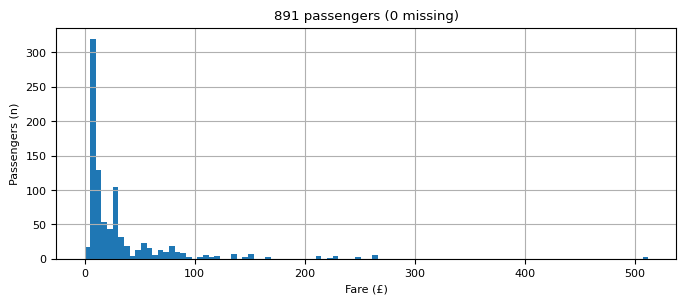

In [12]:
plt.figure(figsize=(8,3))
train['Fare'].hist(bins=100)
plt.xlabel('Fare (£)')
plt.ylabel('Passengers (n)')
plt.title(f"{train['Fare'].dropna().shape[0]} passengers ({sum(train['Fare'].isna())} missing)")
plt.show()

We can see that Fares are clearly not Gaussian either, which again is no suprise given that tickets cannot have negative prices. We could try log-transforming the data, but there are several passengers that paid £0 for their tickets (and for which we would get an error transforming). These were generally employees of ship lines that will be discussed in Chapter 2 and marking these data as missing (or at least not applicable) might make sense for several reasons. Here, we'll apply a log-transform after removing zero fares:

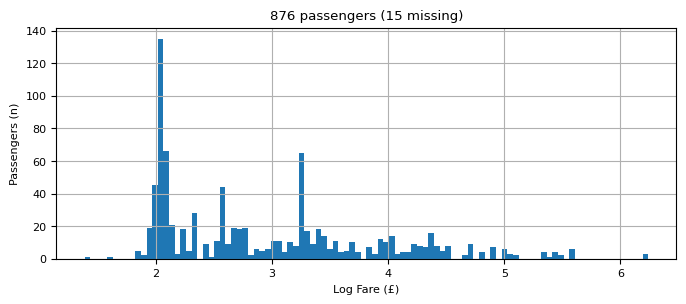

In [13]:
train['log_fare'] = np.log(train['Fare'].replace({0.0:np.nan}))

plt.figure(figsize=(8,3))
train['log_fare'].hist(bins=100)
plt.xlabel('Log Fare (£)')
plt.ylabel('Passengers (n)')
plt.title(f"{train['log_fare'].dropna().shape[0]} passengers ({sum(train['log_fare'].isna())} missing)")
plt.show()

<span style="font-size:14px;line-height:1.5">
<p> 
After the log transform, we can see some separation of the data - potentially into two or three distributions that might correspond to different classes.
</p><p> 
So if class improves your chance of survival, presumably a more expensive ticket is associated with survival too? To see if this is true in the training data, we'll use a reverse correlation approach: that means, rather than ask what the survival rates were for passengers paying different fares, we ask how much did people who survived or perished pay? Seaborn makes this easy to plot:</span>

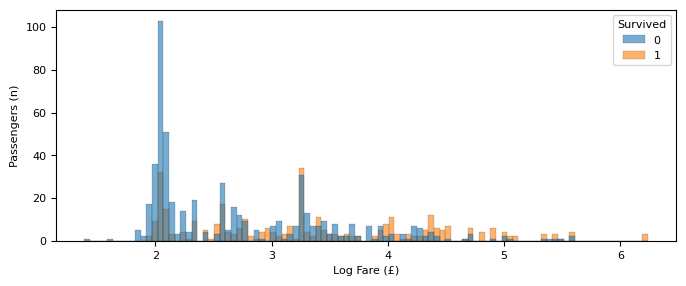

In [14]:
import seaborn as sns

plt.figure(figsize=(8,3))
sns.histplot(data=train, x='log_fare', hue='Survived', bins=100, **{'lw':0.1, 'alpha':0.6})
plt.xlabel('Log Fare (£)')
plt.ylabel('Passengers (n)')
plt.show()

<span style="font-size:14px;line-height:1.5">
<p>
As expected, the higher paying passengers were more likely to survive.
</p>

### 1.2.5. Tickets (and Group Size)
<p>
When you pay your money, you get a ticket for travel. Is there anything we can learn from the ticket data?
</p><p>
There aren't any missing tickets, but we do find that multiple passengers are travelling on the same ticket.
</p><span>

In [15]:
print(f"There are {sum(train['Ticket'].isna())} missing tickets")
print(f"There are {train['Ticket'].nunique()} unique tickets for {train.shape[0]} passengers")

There are 0 missing tickets
There are 681 unique tickets for 891 passengers


<span style="font-size:14px;line-height:1.5">
Travelling on the same ticket_class is likely to indicate some close association between those people travelling. Indeed if we look at the most popular ticket, we see that the passengers appear to be from the Andersson family.
</span>

In [16]:
ticket_info = pd.DataFrame(
        train['Ticket'].value_counts()      # Count number of people travelling on the same ticket
        .reset_index()
        .rename({
            'Ticket':'people_on_ticket',        # minor reformatting that makes life easier later
            'index':'Ticket'
            }, axis=1)
    )

ticket_info.head(3)

,Ticket,people_on_ticket
0,347082,7
1,CA. 2343,7
2,1601,7


In [17]:
# Show data for the most popular ticket 
most_popular_tickets = ticket_info.loc[ ticket_info['people_on_ticket'].idxmax(),:]
train[train['Ticket'] == most_popular_tickets.Ticket][['Ticket','Name','Age','Survived']]

,Ticket,Name,Age,Survived
13,347082,"Andersson, Mr. Anders Johan",39.0,0
119,347082,"Andersson, Miss. Ellis Anna Maria",2.0,0
541,347082,"Andersson, Miss. Ingeborg Constanzia",9.0,0
542,347082,"Andersson, Miss. Sigrid Elisabeth",11.0,0
610,347082,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",39.0,0
813,347082,"Andersson, Miss. Ebba Iris Alfrida",6.0,0
850,347082,"Andersson, Master. Sigvard Harald Elias",4.0,0


<span style="font-size:14px;line-height:1.5">
<p>
Sadly none of the family survived. Is it the case that larger groups had lower survival rates? (Note that the test/train split means we're only looking at partial data here and some tickets may be split across the datasets).
</p><p>
To answer this question, it would be helpful to add a column to the dataset indicating, for each passenger, how many people were travelling on the same ticket:
</p></span>

In [18]:
# Add group size as an extra column to the training set
train = pd.merge(train, ticket_info, left_on='Ticket', right_on='Ticket')

<span style="font-size:14px;line-height:1.5">
And now if we look at survival rates, we see a <i>non-linear</i> relationship, where chances of survival are best for group sizes of three and decline for both larger and smaller groups:
</span>

In [19]:
(
    train.groupby('people_on_ticket')
    .agg({'Survived':['count', 'sum', 'mean']})
    .rename(columns={'count':'total','sum':'n_survived','mean':'proportion'})
)

Survived                      
                    total n_survived proportion
people_on_ticket                               
1                     547        163   0.297989
2                     188        108   0.574468
3                      63         44   0.698413
4                      44         22   0.500000
5                      10          0   0.000000
6                      18          0   0.000000
7                      21          5   0.238095

<span style="font-size:14px;line-height:1.5">
<p>It is important to note the relationship between survival and number of people is non-linear because this affects the kinds of models that we can fit to the data. Generalized linear models would not be able to capture this association well, whereas a random forest or GAM (generalized additive model) might be more appropriate.
More generally, this example illustrates how there are hidden nuggets of information throughout the dataset that can be found through some detective work and intuitive feature engineering.</p><p>We need to apply this engineering to the test data at some point; but we have to be careful how this is done to avoid <b>data leakage</b>. For example, we can't include tickets from the test data in our calculation of group size, even though it's likely that some tickets have passengers in each dataset. Why can't we merge test and train data to calculate group size for tickets? Doing so would mean that data from the test set could influence any model that we subsequently fitted and thus give us an unfair advantage. This might be tempting when we have only one test dataset, but in general it's bad practice as it would harm our ability to generalize in the long term.
</p><p>
Could we use ticket numbers from the train data to calculate group size in the test data? This seems more permissible because we are not fitting any model to the test data, we're just making predictions. Consider for example a case where the test dataset consisted of only a single passenger. In this situation, we wouldn't be able to calculate group size from the test dataset alone. However we could use our past knowledge of the training set to extend what we know about the test passenger.
</p></span>

In [20]:
test = (
    pd.merge(test, ticket_info, left_on='Ticket', right_on='Ticket', how='left')    # add group size in train data as column
    .fillna(0)
)

test['people_on_ticket'] += 1     # Include current passenger in group
test['people_on_ticket'].value_counts()

1.0    266
2.0     80
3.0     45
5.0     11
8.0      5
4.0      5
6.0      3
7.0      3
Name: people_on_ticket, dtype: int64

<span style="font-size:14px;line-height:1.5">
<p>Is there anything else we can learn from ticket information? Generally ticket values contain a number, as well as possible location information (e.g. PARIS, SOTON [probably Southampton]) in a prefix. It is interesting that these locations extend beyond ports of embarcation, although the port codes may be useful for interpretting prefixes (C: Cherebourg, Q: Queenstown, S: Southampton).
</p><p>
There are some unique exceptions such as sailors from other shipping companies travelling on 'LINE' tickets, for which we can add a placeholder ticket value (0) in order to separate the ticket number and prefix.
</p></span>

In [21]:
def get_ticket_number(df):
    return (
        df['Ticket']
        .str.replace('LINE', 'LINE 0')          # Use 0 to indicate missing number on tickets for LINE passengers
        .str.split(' ').str[-1].astype(int)     # Return numbers as integers 
    )

train['ticket_num'] = get_ticket_number(train)
test['ticket_num'] = get_ticket_number(test)

In [22]:
def get_ticket_prefix(df):
    return (
        df
        .apply(lambda x: x['Ticket'].replace(str(x['ticket_num']), ''), axis=1)      # Remove ticket number
        .str.lower()                                                            # Remove differences in case
        .str.replace("[^a-z0-9]","", regex=True)                                # Remove special characters from prefix 
    )

train['ticket_prefix'] = get_ticket_prefix(train)
test['ticket_prefix'] = get_ticket_prefix(test)

# Tickets without prefixes are noted as empty strings, which might be unhelpful and so we add a column to be explicit about the missing data
train['no_ticket_prefix'] = train['ticket_prefix'] == ''
test['no_ticket_prefix'] = test['ticket_prefix'] == ''

<span style="font-size:14px;line-height:1.5">
Looking at the survival rates, we can see there are ticket prefixes for which survival is particularly high (e.g. PC) or low (a4/a5). Looking at the classes for each ticket type, we can see that these categories are specifically first or third class and thus prefix might indicate a particular sub-set of ticket holders (e.g. premium first class, or 3rd class shared accomodation for men).
</span>

In [23]:
pd.DataFrame(
    train
    .replace({'Sex':{'male':0, 'female':1}})      # convert category to number for averaging
    .groupby('ticket_prefix')
    .agg({'Survived':['count', 'sum', 'mean'], 'Age':['mean'], 'Pclass':['unique'], 'Fare':['median'], 'Sex':['mean']})
    .rename(columns={'count':'total','sum':'n_survived'})
    .sort_values(by=('Survived','total'), ascending=False)
).head()

Survived                             Age     Pclass    Fare  \
                 total n_survived      mean       mean     unique  median   
ticket_prefix                                                               
                   661        254  0.384266  29.435067  [1, 3, 2]  13.000   
pc                  60         39  0.650000  37.120000        [1]  79.200   
ca                  41         14  0.341463  25.090909     [2, 3]  26.250   
a5                  21          2  0.095238  30.805556        [3]   8.050   
stono2              18          8  0.444444  27.722222        [3]   7.925   

                    Sex  
                   mean  
ticket_prefix            
               0.361573  
pc             0.483333  
ca             0.365854  
a5             0.095238  
stono2         0.277778

<span style="font-size:14px;line-height:1.5">
How can we turn this information into a useful feature for predicting test survival? One way would be to treat prefix as a category and then use <b>one-hot encoding</b> to train a model. There are quite a few cases where sample sizes for individual ticket types are small and so we might want to convert these prefix types into one alternative category ('other').</p>
<p>Another solution would be to use <b>target encoding</b> in which we replace ticket prefixes with values related to survival and use this as a single feature. Here, the encoding map built from the training data could be applied to the test data without risk of leakage. To minimise noise associated with small sample sizes, we could consider using the same 'other' bin for any prefix that has one or a few passengers, and this bin could also be used to assign ticket prefixes in the test set that are not in our mapping. (Or those prefixes could be discarded)</p>
<p>Finally, we could try to learn an <b>embedding</b> in which tickets exist within some space, where tickets with similar prefixes/numbers and passenger survival are close together. We will discuss each of these approaches in Chapter 3.

### 1.2.6. Port of Embarcation

There are three ports at which passengers (of all classes and genders) boarded the titanic, listed here in order along the journey: Cherbourg (France), Southampton (UK) and Queenstown (Ireland). As one might expect, tickets were more expensive the further one travelled, but there is also evidence of demographic differences, with travellers from Cherbourg being more likely to travel in a higher class, while passengers boarding in Queenstown tended to travel more often in 3rd class (which might also account for at least part of the difference in fare):
</span>

In [24]:
port_codes = dict(C = 'Cherbourg', Q = 'Queenstown', S = 'Southampton')

(train
    .replace({'Embarked':port_codes})
    .groupby('Embarked')
    .agg({'Survived':['count', 'sum', 'mean'], 'Age':['mean'], 'Pclass':['mean'], 'Fare':['median']})
    .sort_values(('Fare','median'), ascending=False)
)

Survived                       Age    Pclass   Fare
               count  sum      mean       mean      mean median
Embarked                                                       
Cherbourg        168   93  0.553571  30.814769  1.886905  29.70
Southampton      644  217  0.336957  29.445397  2.350932  13.00
Queenstown        77   30  0.389610  28.089286  2.909091   7.75

<span style="font-size:14px;line-height:1.5">
<p>The location at which passengers joined the ship might tell us something about the travellers. We will come back to this when we look at ticket. For now it's clear that there is some correlation between the port of embarcation and other variables.</p>

### 1.2.7. Cabin

Cabin information is comprised of a letter and number (e.g. G6), which we will call the "section" and "room number"; However some passengers have multiple rooms (B96 B98) and some rooms have multiple passengers. There are also a small number of deviations from the standard format, where passengers have a single letter only (e.g. 'T') or a single letter before a cabin number (e.g. 'F G63'). First thing we'll do is harmonise the letter formatting by adding a placeholder value:
</span>

In [25]:
# Remove single letters from records with other column names (e.g. turn 'F G74' to 'G74')
idx = train[train['Cabin'].str.match(r'[A-Z]\s[A-Z0-9]*').fillna(False)].index
train.loc[idx,'Cabin'] = train.loc[idx, 'Cabin'].str.extract(r'([A-Z]\s)([A-Z0-9]*)')[1]

<span style="font-size:14px;line-height:1.5">
<p>
Next, let's add a column to show the number of cabins someone has. This might be important in future for processing string 
information in cabin names later on. Where there is no cabin information, we will assume that person had a single room (which may be inferring too much at this point).
</span>

In [26]:
train['n_rooms'] = 1 + train['Cabin'].str.count(' ').fillna(0).astype(int)

print(f"{sum(train['n_rooms'] > 1)} / {train.shape[0]} passengers have multiple rooms. Unique room combinations:")

train[train['n_rooms'] > 1]['Cabin'].unique()

20 / 891 passengers have multiple rooms. Unique room combinations:


array(['C23 C25 C27', 'D10 D12', 'B58 B60', 'B82 B84', 'B51 B53 B55',
       'C22 C26', 'B57 B59 B63 B66', 'C62 C64', 'B96 B98'], dtype=object)

<span style="font-size:14px;line-height:1.5">
<p>
Passengers with multiple cabins stay within the same section. Each section represents a major division of the ship associated with different classes of accomodation. Let's extract the first letter indicating the section and see what differs between sections:</p></span>

In [27]:
train['Section'] = train['Cabin'].str.get(0)
(
    train
    .fillna({'Section':'Missing'})
    .groupby('Section')
    .agg({
        'Fare':['median'],
        'Pclass':['unique'], 
        'n_rooms':['unique'], 
        'Survived':['count', 'sum', 'mean'],
        })
)

Fare     Pclass       n_rooms Survived               
          median     unique        unique    count  sum      mean
Section                                                          
A        35.5000        [1]           [1]       15    7  0.466667
B        80.0000        [1]  [1, 2, 3, 4]       47   35  0.744681
C        83.4750        [1]     [1, 3, 2]       59   35  0.593220
D        53.1000     [2, 1]        [1, 2]       33   25  0.757576
E        38.5000  [1, 2, 3]           [1]       33   25  0.757576
F        26.0000     [2, 3]           [1]        9    7  0.777778
G        10.4625        [3]           [1]        7    2  0.285714
Missing  10.5000  [3, 2, 1]           [1]      687  206  0.299854
T        35.5000        [1]           [1]        1    0  0.000000

<span style="font-size:14px;line-height:1.5">
<p>There's a lot of insight in this table: Section B and C look like the best places to stay, with more expensive fares and more rooms. What is also striking is that survival rates in nearly every group in which we have Cabin information are better than when Cabin information is missing. 
</p><p>
As we will see later, cabin data is missing primarily for 2nd and 3rd class passengers (92 and 98% respectively, vs. 21% of 1st Class passengers). We will also look at the relationship between Cabin and Ticket number - something that might allow us to infer the section in which passengers were staying.
</p></span>

### 1.2.8. Names
<span style="font-size:14px;line-height:1.5">
Dealing with text data is always a pain in the ass, as the format of the data is so variable. Here are some examples of the formats in the Name column:
</span><br></br>

| Format | Example |
| --- | --- |
| Surname, Title. FirstName MiddleName | Backstrom, Mr. Karl Alfred |
| Surname, Title. FirstName | Ayoub, Miss. Banoura |
| Surname, Title. HusbandsFirstName, HusbandsMiddleName  (FirstName, MiddleName, MaidenName) | Backstrom, Mrs. Karl Alfred (Maria Mathilda Gustafsson) |
| Surname, Title. HusbandsFirstName, HusbandsMiddleName  (FirstName, MaidenName) | Baclini, Mrs. Solomon (Latifa Qurban) |
| Surname, Title. (FirstName, MaidenName) | Barbara, Mrs. (Catherine David) |
| Surname, Title. FirstName MiddleName (AltSurname) | Andersson, Mr. August Edvard ("Wennerstrom") |

There are also inconsistencies in spelling, for example between 'Ms' and 'Miss'



#### What useful information can we get from passenger names?
<span style="font-size:14px;line-height:1.5">
Titles gives some clues as to the ages of passengers that may be helpful in later imputation of missing data. For example:
<ui>
<li> "Master" - a young boy (between ages of 0 and 15 [the oldest case, in the test dataset])</li>
<li> "Miss" - a young woman (although Miss may continued to be used throughout life due to its association with marriage, as indicated in the extended age range of 0-63 years)</li>
</ui>
The use of the husbands name for some women also indicates the marriage relationship, which may be of interest if, for example, being married is likely to enhance a woman's chance of survival or decrease a man's chance of survival.
</span>

In [28]:
# Let's start by extracting the consistent fields - everyone has a surname and title (I think... though there's no type checking)
train['Surname'] = train['Name'].str.split(pat='[,.]', n=2, expand=True)[0]
train['Title'] = train['Name'].str.split(pat='[,.]', n=2, expand=True)[1]

test['Surname'] = test['Name'].str.split(pat='[,.]', n=2, expand=True)[0]
test['Title'] = test['Name'].str.split(pat='[,.]', n=2, expand=True)[1]

In [29]:
# Now, let's replace the various title spellings an
inconsist_titles = {'Ms':'Miss','Mlle':'Miss','Mra':'Mrs','Mme':'Mrs','Don':'Mr','Dona':'Mrs'}

def correct_inconsistencies(df, str_map:dict):
    for key, value in str_map.items():
        df['Title'] = df['Title'].str.replace(key,value)
    
    return df

train = correct_inconsistencies(train, inconsist_titles)
test = correct_inconsistencies(test, inconsist_titles)

In [30]:
# There are a few people with professional titles
professional_titles = ['Dr','Rev','Major','Col','Capt']

train['professional_title'] = train['Title'].str.contains('|'.join(professional_titles))
test['professional_title'] = test['Title'].str.contains('|'.join(professional_titles))

# Those with professional titles were less likely to survive
train.groupby('professional_title')['Survived'].mean()

professional_title
False    0.386025
True     0.277778
Name: Survived, dtype: float64

In [31]:
# There are several people with aristocratic titles
nob_title = ['Sir','Countess','Lady', 'Jonhkeer']

train['nob_title'] = train['Title'].str.contains('|'.join(nob_title))
test['nob_title'] = test['Title'].str.contains('|'.join(nob_title))

# They all survived... 
train.groupby('nob_title')['Survived'].mean()

nob_title
False    0.381757
True     1.000000
Name: Survived, dtype: float64

In [32]:
test['Title'].value_counts()

 Mr        240
 Miss       79
 Mrs        72
 Master     21
 Col         2
 Rev         2
 Dr          1
 Mra         1
Name: Title, dtype: int64

In [33]:
bracket_idx = train[train.Name.str.contains(r'\([^)]*\)')].index
bracket_names = train.loc[bracket_idx]

male_bracket_idx = bracket_names[bracket_names.Sex == 'male'].index
male_bracket_names = bracket_names.loc[male_bracket_idx]

male_bracket_names.Name.to_list()


['Moubarek, Master. Halim Gonios ("William George")',
 'Petroff, Mr. Pastcho ("Pentcho")',
 'Andersson, Mr. August Edvard ("Wennerstrom")',
 'Navratil, Mr. Michel ("Louis M Hoffman")',
 'Romaine, Mr. Charles Hallace ("Mr C Rolmane")',
 'Lovell, Mr. John Hall ("Henry")',
 'Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")',
 'Morley, Mr. Henry Samuel ("Mr Henry Marshall")',
 'Pickard, Mr. Berk (Berk Trembisky)',
 'Bradley, Mr. George ("George Arthur Brayton")',
 'Leeni, Mr. Fahim ("Philip Zenni")',
 'Flynn, Mr. John Irwin ("Irving")',
 'Homer, Mr. Harry ("Mr E Haven")',
 'Harmer, Mr. Abraham (David Lishin)']

### 1.2.9. Social Connections

<span style="font-size:14px;line-height:1.5">
The columns <b>sibsp</b> (Siblings and Spouses) and <b>Parch</b> (Parents and children) indicate relatedness between passengers. One might expect this to impact survival chances. We can visualize the connections between individuals as follows:

![Diagram indicating the intra-generational and inter-generation relationships contained within sibsp and Parch columns](social_relationships.png "Social relationships")

* Includes step-children; some children travelled only with a nanny (parch=0)

Does not include connections between unrelated individuals travelling together (e.g. children with nanny, unmaried couples etc.). The information in these two columns may reveal more about the family situation of individuals that may be related to surival. For example, the sum of relatives can tell us something about family size:

</span>

In [34]:
train['family_size'] = train['Parch'] + train['SibSp']
(
    train.groupby('family_size')
    .agg({'Survived':['count', 'sum', 'mean']})
    .T
)

family_size             0           1           2          3     4   \
Survived count  537.000000  161.000000  102.000000  29.000000  15.0   
         sum    163.000000   89.000000   59.000000  21.000000   3.0   
         mean     0.303538    0.552795    0.578431   0.724138   0.2   

family_size            5          6    7    10  
Survived count  22.000000  12.000000  6.0  7.0  
         sum     3.000000   4.000000  0.0  0.0  
         mean    0.136364   0.333333  0.0  0.0

<span style="font-size:14px;line-height:1.5">
This non-linear pattern of survivorship mirrors the relationship we saw before with the number of people travelling on the same ticket. These variables are quite strongly correlated (r = 0.74), although not perfectly, which may indicate there is some additional information in ticket group size (e.g. social connections not represented through relatedness)
<span>

In [ ]:
train[['family_size','people_on_ticket']].corr()

<span style="font-size:14px;line-height:1.5">
<p>One could imagine using relatedness to build something more informative like a social graph in which relatives are located more closely to one another than unreleated individuals from the same demographics. It might also be possible to combine social relationships with other variables such as age to build features such as the likelihood of being a parent or child. We will consider these further in Chapter 3 on feature engineering.
</p><p>

### 1.2.10. PassengerId

This should just be a unique index for use as a primary key. Let's check:</span>

In [ ]:
train['PassengerId'].is_unique
# test['PassengerId'].is_unique

<span style="font-size:14px;line-height:1.5">
We don't intend to use passenger Id in our model, but it's useful to just double check that there's no obvious relationship between this key and survival. It's possible in some datasets that the initial data collection is not random, for example if everyone who survived was listed first and thus had higher passenger IDs than those that died. If we only care about predictive performance, then we could exploit such a relationship. There isn't anything obvious in this particular dataset, but you'd be surprised how often primary keys contain information.
</span>

In [ ]:
train.plot.scatter(x='PassengerId', y='Survived')
# plt.xlim((0, 40))
plt.show()

---
## 1.3. Interactions between features
<span style="font-size:14px;line-height:1.5">
Within our dataset, we have a number of features that might be correlated, or interact in interesting ways. For example, we might expect children to pay less for tickets than adults, or that the effect of gender on survival is limited to adults. Identifying interactions of interest of important for specifying the design of statistical models, or where we fit full models (models that consider all features and all interactions between features, with appropriate regularization), for assessing the outcome of the fitting procedure. It also helps us think about the kind of higher dimensional spaces that models can explore to fit the data - for example, to find 
</span>

### 1.3.1. Gender & Age

<span style="font-size:14px;line-height:1.5">
The top plot above shows that very young children do indeed have the best survival rates, but this benifit is lost by the time we reach ages 10-15. This highlights how the definition of concepts (e.g. childhood) is culturally and temporally specific.

Looking at the age profile for men and women also reveals that children were drawn from equal demographics, whereas from the mid-teens up until the sixties, the skew is for there to be more men. </span>

In [ ]:
sns.lineplot(
    data = pd.DataFrame(train.groupby(['Sex','age_group'])['Survived'].mean()),
    x = 'age_group',
    y = 'Survived',
    hue = 'Sex',
)
plt.show()

However as we also predicted, there is a clear interaction between age and gender, with the gender of children under 5 less irrelevant and then age becoming more important in lowering the survival rates of men and not women (who's survival actually increases with age).

### 1.3.2. Gender and Class

<span style="font-size:14px;line-height:1.5">
 <p>
Yes, paying more increases your chances of survival - although only up to a point if you're a man. The demographics of fares also shows an interesting difference - the fare for a woman's ticket is on average more than a man's.  That makes sense if you consider that the gender ratio in first and second class is closer to parity, whereas a larger number of men in 3rd class are the driver for the lower fares.
</p><p>
The plots below confirm this, and also show an interaction with gender, where the biggest difference in survival between men and women was in second class.
 </p></span>

In [ ]:

survival_by_class_gender = train.groupby(by=['Sex','Pclass'])['Survived'].mean()
survival_by_class_gender.plot.bar(color=['gold','silver','k'], ax=axs[1])

train.groupby('YrsOld')['Survived'].mean().plot(ax=axs[0])
train.groupby('age_group')['Survived'].mean().plot(ax=axs[0], **{'marker':'.'})
axs[0].set_ylabel('Survived (p)')

sns.lineplot(
    data = pd.DataFrame(train.groupby(['Sex','age_group'])['Pclass'].count()),
    y = 'class',
    x = 'age_group',
    hue = 'Sex',
    palette = 'Set2'
)
axs[1].set_ylabel('n')

plt.show()

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure()
gs = fig.add_gridspec(2,4)

ax_0 = sns.lineplot(
    data = pd.DataFrame(fare_group_survival).reset_index(),
    x = 'fare_group',
    y = 'Survived',
    hue = 'Sex',
    palette = 'Set2',
    ax = fig.add_subplot(gs[0,0:3])
)

ax_0.set_xscale('log')

ax_1 = sns.barplot(
    data = pd.DataFrame(fare_group_samplesize).reset_index(),
    x = 'fare_group',
    y = 'Survived',
    hue = 'Sex',
    palette = 'Set2',
    ax = fig.add_subplot(gs[1,0:3])
)

ax_1.set_ylabel('Passengers (n)')
# ax_1._legend.set_visible(False)

# Plot class of passengers by gender
count_by_class_gender = (
    pd.DataFrame(
        train[['class','Sex','Fare']]
        .groupby(['Sex','class'])
        .count()
    )
    .reset_index()
    .sort_values(by='Sex')
    .rename({'Fare':'N'}, axis=1)
)

ax_2 = sns.barplot(
    data = count_by_class_gender,
    x = 'class',
    y = 'N',
    hue = 'Sex',
    palette = 'Set2_r',
    ax = fig.add_subplot(gs[:,3])
)

sns.despine(ax=ax_0)
sns.despine(ax=ax_1)
sns.despine(ax=ax_2)

# ax_1.legend().remove()
# ax_2.legend().remove()
plt.show()

In [ ]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2,2)

ax_1 = sns.stripplot(
    data=train, 
    x="Fare", 
    y="class", 
    hue="Sex", 
    jitter = True,
    size = 2,
    palette = 'Set2',
    alpha = 0.5,
    dodge=True,
    ax = fig.add_subplot(gs[0,:])
    )

ax_2 = sns.violinplot(
    data=train, 
    x="Fare", 
    y="class", 
    hue="Sex", 
    split = True,
    palette = 'Set2',
    legend=False,
    ax = fig.add_subplot(gs[1,:])
    )


ax_2.set_xlim(ax_1.get_xlim())

plt.show()

### 1.3.3. Ticket and Port of Embarcation

One might wonder if ticket numbers contained the port of embarcation that might help us parse the other information in the ticket information. While there do seem to be some small details (for example, people boarding in Cherbourg include those with tickets mentioning Paris and Basel), there's no obvious connection.

In [ ]:
for port, port_data in train.groupby('Embarked'):
    print(f"Port = {port}, ticket_prefixes = {port_data['ticket_prefix'].sort_values().unique()}")

### 1.3.4. Cabin

Since so many cabin numbers are missing, it would be interesting to know if there's anything that predicts where passengers were staying on the ship. Ideally this might help us impute missing cabin (at least section information)

#### 1.3.4.1. Ticket
Individual sections don't appear to be associated in an obvious way with ticket number ranges:

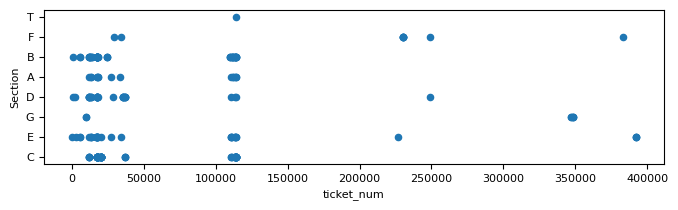

In [55]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot()
train[['ticket_num','Section']].dropna().plot.scatter(x='ticket_num', y='Section', ax=ax)
plt.show()

Unfortunately there's also a lot of missing cabins for passengers with ticket prefixes

In [64]:
index = train[train['ticket_prefix'] != ''].index

train.loc[index, ['Ticket','ticket_prefix','Cabin','Section']]

,Ticket,ticket_prefix,Cabin,Section
0,A/5 21171,a5,NaN,NaN
1,PC 17599,pc,C85,C
2,STON/O2. 3101282,stono2,NaN,NaN
17,PP 9549,pp,G6,G
18,PP 9549,pp,G6,G
...,...,...,...,...
865,PC 17592,pc,D28,D
874,SC/PARIS 2149,scparis,NaN,NaN
875,PC 17590,pc,A24,A
885,C.A./SOTON 34068,casoton,NaN,NaN


In [68]:
train[(train['ticket_prefix'] == '') & (~train['Cabin'].isna())].shape

(150, 26)

---
## 1.4. Conclusions

<span style="font-size:14px;line-height:1.5">
<p><b>Identifying missing data</b></p><p>
In this chapter, we took our first look through the dataset. Initial inspection of the data highlighted that several columns (e.g. Age and Cabin) contain missing data. Most often missing data was encoded as NaNs, but we also found some examples where missing data was a part of a string (e.g. prefixes on ticket numbers) or required us to thing further about the meaning of the data itself (in the case of passengers paying zero Fare). We saw how the absence of this data can itself be informative about survival, if the data are not missing at random, and we created features with the specific intention of encoding whether data was present or absent. In chapter 2, we will explore these issues further and see how we can estimate the values of these missing data using different methods. 
</p><p>
<b>Distributions</b></p><p>
When visualizing the distribution of continuous variables in the data such as Fare highlighted that such features are not normally distributed and may require transformation. When it was not clear if a variable such as Age had a normal distribution, we used a statistical test (the Kolmogorov-Smirnov test) to provide an objective decision. The absence of normal distributions is not surprising, given we know that most continuous variables in the dataset are non-negative.
</p><p>
<b>Intuitive relationships</b></p><p>
Within the data, we saw relationships that match our expectations about survival of passengers on a sinking ship in terms of age, class and gender. This gives us confidence that there is information within the features that will allow us to predict survival on the test dataset. Though we might expect to be confident in the case of this specific dataset, it's always important to consider whether data make sense and that there is actually some information to extract.
</p><p>
<b>Next Steps</b></p><p>
Finally, we began to extract more of this information from variables such as Name and Ticket Number, and build features such as the profession of passengers, the number of people they were travelling with etc.  

</p><p>
In the next chapter, we will take feature engineering further to consider some of the advanced tools for thinking about the problem of predicting survival. Although Chapters 2 and 3 address Imputation and Feature Engineering separately, this order should not be taken to imply that one step should necessarily be done before or after the other. Some might argue that imputation is a form of feature engineering and there are certainly synergies between the two processes; engineering features can improve the quality of imputation, while imputation can open up new opportunities for feature engineering. 
</p><p>
The pipeline for our analysis therefore looks like the diagram below, with multiple pathways and the potential for iterative refinement of the data through multiple steps. If we're fortunate enough to have a full dataset (i.e. no missing data) and we're specifically interested in the primary data, we can go straight to Chapter 4 and the prepration of data for machine learning. This chapter will conclude the first part of the book before we look at the potential options for predicting survival in Part II.
</p>


![Flow-chart for progress from exploratory data analysis to preparations for machine learning](part_1_layout.png "Flow chart")

</span>

